In [0]:
from google.colab import drive
drive.mount('/content/drive')

!pip install facenet-pytorch 
!pip install mmcv
!pip install albumentations


from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
import mmcv, cv2
import albumentations as A
from IPython import display

display.clear_output()

In [0]:
import albumentations as A

import os, glob, shutil, sys
import time
from functools import reduce

import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('Solarize_Light2')

from PIL import Image, ImageDraw

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

ABS_PATH = '/content/drive/My Drive/Colab Notebooks/facenet/'
DATA_PATH = ABS_PATH + 'data/'
TEST_DIR = DATA_PATH + 'test_images'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'


def collate_fn(x):
    return x[0]

transform = transforms.Compose([
                           transforms.ToTensor()
])

resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)
dataset = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=transform)
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()} 

aligned = []
names = []

test_loader = DataLoader(dataset, collate_fn=collate_fn, batch_size=1)
for x, y in test_loader:
    aligned.append(x)
    names.append(y)

aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

names = [dataset.idx_to_class[idx] for idx in names]
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
print(pd.DataFrame(dists, columns=names, index=names))

Running on device: cuda:0
                   andrey_boykovskiy  danya_nebeskiy  ...     vanya  vitali_kulinich
andrey_boykovskiy           0.000000        0.870752  ...  0.440689         0.492770
danya_nebeskiy              0.870752        0.000000  ...  0.918442         0.874359
denis_moroz                 0.396290        0.896605  ...  0.439214         0.366557
denis_trishuk               0.914978        0.768454  ...  1.041779         0.806686
dmytro_zikratyi             0.384556        0.878678  ...  0.396179         0.553008
heorgii_bolotov             0.431793        0.941801  ...  0.158876         0.582082
kolya_zubets                0.395428        1.034718  ...  0.289566         0.623269
sacha_musak                 0.396633        0.944872  ...  0.263768         0.559009
vanya                       0.440689        0.918442  ...  0.000000         0.576324
vitali_kulinich             0.492770        0.874359  ...  0.576324         0.000000

[10 rows x 10 columns]


In [0]:
import albumentations as A

import os, glob, shutil, sys
import time
from functools import reduce

import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('Solarize_Light2')

from PIL import Image, ImageDraw

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Running on device: {device}')

ABS_PATH = '/content/drive/My Drive/Colab Notebooks/facenet/'
DATA_PATH = ABS_PATH + 'data/'
TRAIN_DIR = DATA_PATH + 'train_images'
TEST_DIR = DATA_PATH + 'test_images'
ALIGNED_TRAIN_DIR = TRAIN_DIR + '_cropped'
ALIGNED_TEST_DIR = TEST_DIR + '_cropped'

sys.path.append(ABS_PATH)

# CUSTOM functions
from plotter import plot_img, plot_batch, plot_rnd


CROP_FACE = True
IMG_SIZE = (160, 160)

IDX_TO_CLASS = dict() # filled with idx: class from train_dataset

NUM_CLS = max(len(datasets.ImageFolder(TRAIN_DIR).classes), len(datasets.ImageFolder(TEST_DIR).classes))

MTCNN_PARAMS = {
    'image_size': max(IMG_SIZE), 'margin': 0, 'min_face_size': 10, 'thresholds': [0.6, 0.7, 0.7],
    'factor': 0.709, 'post_process': False, 'device': device,
}


def find_faces(model, path: str, new_path=None, resize=(620, 620)):
    """
    Function to find faces on images and save new images in: new_path or if new_path is None, path + '_cropped'

    :param model: model to detect faces
    :param path: dir with images to find/crop faces
    :param new_path: dir to save new images images
    :param size: resize images
    """

    new_path = path + '_cropped' if new_path is None else new_path
    if os.path.exists(new_path):
        shutil.rmtree(new_path)

    dataset = datasets.ImageFolder(path, transform=transforms.Resize(resize))
    dataset.samples = [(p, p.replace(path, new_path)) for p, _ in dataset.samples]
    loader = DataLoader(
        dataset,
        num_workers=1,
        batch_size=64,
        collate_fn=training.collate_pil
    )

    print(f'\nNew images saved in {path}')
    for i, (x, y) in enumerate(loader):
        model(x, save_path=y)
        print(f'\nBatch {i + 1} of {len(loader)}', end='')


# ------------       FIND FACES AND CROP THEM       ------------

if CROP_FACE:
    # Model to detect faces
    mtcnn = MTCNN(**MTCNN_PARAMS)

    # PREPROCESS original images(detect face, resize, save in new dir)
    find_faces(mtcnn, TRAIN_DIR, ALIGNED_TRAIN_DIR)
    find_faces(mtcnn, TEST_DIR, ALIGNED_TEST_DIR)

    del mtcnn
    time.sleep(10)
    display.clear_output()

# ---------------------------------------------------------------


dataset = datasets.ImageFolder(ALIGNED_TRAIN_DIR)
IDX_TO_CLASS = {idx: cls for cls, idx in dataset.class_to_idx.items()}
del dataset


# for x, y in train_loader:
#     y = np.array([IDX_TO_CLASS[y_.item()] for y_ in y])
#     plot_rnd(x, y)

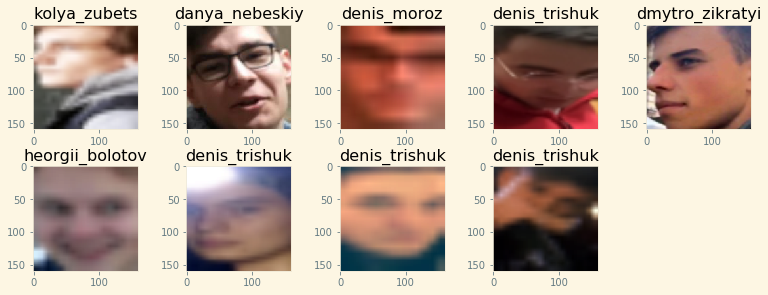

In [0]:
resnet.eval()
for x, y in test_loader:
    logits = resnet(x.to(device))
    probs = torch.softmax(logits, dim=1)
    preds = probs.argmax(dim=1).detach().cpu()
    names = [IDX_TO_CLASS[i.item()] for i in preds]
    plot_batch(x, names, nrow=2, ncol=5)

In [13]:
# ------------       TRANSFORM TRAIN/TEST        ------------

# aug_mask = A.Compose([
#     #  A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.1),
#     A.RandomRotate90(p=0.3),
#     A.HorizontalFlip(p=0.3),
#     A.RandomSizedCrop((IMG_SIZE[0] - 50, IMG_SIZE[1] - 50), *IMG_SIZE, p=0.2),
#     A.MotionBlur(p=0.1, blur_limit=3),
#     A.RandomBrightness(p=0.5),
#     A.RGBShift()
#     A.RGBShift(r_shift_limit=0.1, g_shift_limit=0.1, b_shift_limit=0.1, p=0.2),
# ], p=0.82)
IMG_SIZE = (160, 160)
aug_mask = A.Compose([
    A.OneOf([
        A.IAAAdditiveGaussianNoise(),
        A.GaussNoise(),
    ], p=0.2),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=5, p=0.2),
        A.Blur(p=0.2)
    ], p=0.2),
    # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=0.1),
    A.OneOf([
        A.IAASharpen(),
        A.IAAEmboss(),
        A.RandomBrightnessContrast()
    ], p=0.3),
    A.Rotate(limit=90, p=0.3),
    # A.RandomRotate90(p=0.1),
    A.HorizontalFlip(p=0.1),
    A.RandomSizedCrop((IMG_SIZE[0] - (IMG_SIZE[0] / 10), IMG_SIZE[1] - (IMG_SIZE[1] / 10)), *IMG_SIZE, p=0.1),
], p=0.8)

default_mask = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

mask = transforms.Compose([
    transforms.Lambda(lambda img: img if Image.isImageType(img) else Image.fromarray(img)),
    # transforms.Resize(IMG_SIZE),
    transforms.Lambda(lambda img: aug_mask(image=np.array(img))['image']),  # float32

    default_mask
])

transform = {
    'test': default_mask,
    'train': mask
}


# ---------------------------------------------------------------


def train(model, optimizer, scheduler, loss_fn, metrics, epochs, train_loader, val_loader):
    """

    :param model: model for classification
    :param epochs:
    :param train_loader: contains loader with: (x, y)
    :param val_loader:  same as train_loader
    :return:
    """
    writer = SummaryWriter()
    writer.iteration, writer.interval = 0, 10

    model.eval()

    training.pass_epoch(
        model, loss_fn, val_loader, batch_metrics=metrics, show_running=True,
        device=device, writer=writer
    )

    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-' * 10)

        model.train()
        training.pass_epoch(
            model, loss_fn, train_loader, optimizer, scheduler,
            batch_metrics=metrics, show_running=True, device=device, writer=writer
        )
        model.eval()
        training.pass_epoch(
            model, loss_fn, val_loader, batch_metrics=metrics, show_running=True,
            device=device, writer=writer
        )

    writer.close()
    time.sleep(10)
    display.clear_output()


resnet = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=NUM_CLS).to(device)


def freeze_all(model):
    for p in model.parameters():
        p.requires_grad_(False) 

def unfreeze_n_children(model, kwargs, params):
    for i, (n, m) in enumerate(resnet.named_children()):
        if n == kwargs.get(i):
            for n, p in m.named_parameters():
                if params.get(n): p.requires_grad_(True)

def init_(model, kwargs, params, mean=0.0, std=1):
    for i, (n, m) in enumerate(resnet.named_children()):
        if n == kwargs.get(i):
            for n, p in m.named_parameters():
                if params.get(n): nn.init.normal_(p, mean, std)

freeze_all(resnet)

kwargs = dict(zip(range(13, 17 + 1), ['avgpool_1a', 'dropout', 'last_linear', 'last_bn', 'logits']))
# kwargs = dict(zip([17], ['logits']))
params = {'weight': True, 'bias': True}
unfreeze_n_children(resnet, kwargs, params)

kwargs = dict(zip([17], ['logits']))
params = {'weight': True, 'bias': True}
# init_(resnet, kwargs, params, mean=0.0, std=0.8)


optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.0005)
scheduler = MultiStepLR(optimizer, [5, 10])

loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.MSELoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

epochs = 30
batch_size = 27

train_dataset = datasets.ImageFolder(ALIGNED_TRAIN_DIR, transform=transform['train'])
test_dataset = datasets.ImageFolder(ALIGNED_TEST_DIR, transform=transform['test'])

train_loader = DataLoader(
    train_dataset,
    num_workers=1,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(range(len(train_dataset)))
)
# for x, y in train_loader:
#     print(x.size())

test_loader = DataLoader(
    test_dataset,
    num_workers=1,
    batch_size=batch_size,
)
train(resnet, optimizer, scheduler, loss_fn, metrics, epochs, train_loader, test_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

In [0]:
resnet = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=NUM_CLS).to(device)

In [0]:
# def freeze_all(model):
#     for p in model.parameters():
#         p.requires_grad_(False) 

# def freeze_n_children(model, kwargs, params):
#     for i, (n, m) in enumerate(resnet.named_children()):
#         if n == kwargs.get(i):
#             for n, p in m.named_parameters():
#                 if params.get(n): p.requires_grad_(True)

# def init_(model, kwargs, params, mean=0.0, std=0.8):
#     for i, (n, m) in enumerate(resnet.named_children()):
#         if n == kwargs.get(i):
#             for n, p in m.named_parameters():
#                 if params.get(n): nn.init.normal_(p, mean, std)

# freeze_all(resnet)

# kwargs = dict(zip(range(13, 17 + 1), ['avgpool_1a', 'dropout', 'last_linear', 'last_bn', 'logits']))
# params = {'weight': True, 'bias': True}
# freeze_n_children(resnet, kwargs, params)

# kwargs = dict(zip([17], ['logits']))
# params = {'weight': True, 'bias': True}
# init_(resnet, kwargs, params, mean=0.0, std=0.8)


# for n, p in resnet.named_parameters():
    # print(n, p.requires_grad)
n_children = 11
for i, (n, m) in enumerate(resnet.named_children()):
    if i > n_children:
        print(i, n, m)     
#         print(m.weight)
#         print(m.bias)
        for n, p in m.named_parameters():
            pass
        print(i, n)
        # print(m.parameters())
#         for i, (n, m) in enumerate(m.named_children()):
#             print(i, n)
#         break 

12 block8 Block8(
  (branch0): BasicConv2d(
    (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (branch1): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
      (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
  )
  (conv2d): Conv2d(384, 1792, kernel_size=(

In [0]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [0]:
resnet = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=NUM_CLS).to(device)

model = nn.Sequential([
    nn.AdaptiveAvgPool2d(output_size=1),
    nn.Dropout(p=0.6, inplace=False),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    nn.BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
    nn.Linear(in_features=512, out_features=10, bias=True)
])


In [0]:
!pip install youtube_dl
!youtube-dl -f 135 https://www.youtube.com/watch?v=qmqiQ6FDxL4 -o drive/My Drive/Colab Notebooks/facenet/video.mp4

In [0]:
!pip install Augmentor
!pip install facenet-pytorch 
!pip install mmcv
display.clear_output()

In [0]:
from facenet_pytorch import MTCNN, InceptionResnetV1, training, fixed_image_standardization
import mmcv, cv2
import Augmentor

In [0]:
mtcnn = MTCNN(keep_all=True, device=device)
video = mmcv.VideoReader('video.mp4')
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in video]

frames_tracked = []
for i, frame in enumerate(frames):
    print(f'\rTracking frame: {i + 1}', end='')
    boxes, _ = mtcnn.detect(frame)
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    if boxes is not None:
        for box in boxes:
            draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))

print('\nDone')

In [0]:
d = display(frames_tracked[0], display_id=True)
i = 1
try: 
    while True:
        time.sleep(1)
        d.update(frames_tracked[i])
        i += 1
except KeyboardInterrupt:
  pass

In [0]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()

In [0]:
data_dir = 'drive/My Drive/Colab Notebooks/facenet/data/train_images'
num_cls = sum([1 for x in glob.glob(os.path.join(data_dir, '*'), recursive=True) if os.listdir(x)])
print(f'Num classes to train: {num_cls}')

Num classes to train: 8


In [0]:
img.size

(1568, 2080)

In [0]:
pip install Albumentations

In [0]:
Image.isImageType(np.array(img)), dir(Image.isImageType)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


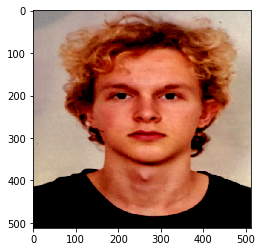

In [0]:
import albumentations as A


# mask2 = A.Compose([
#        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.2),
#        A.RandomRotate90(p=0.3),
#        A.HorizontalFlip(p=0.3),
#        A.RandomSizedCrop((450, 450), 512, 512),
#        A.MotionBlur(p=0.3, blur_limit=5),
#        A.RandomBrightness(p=1),
#        A.RGBShift(r_shift_limit=0.1, g_shift_limit=0.1, b_shift_limit=0.1, p=0.3),   
# ], p=0.8)

# mask1 = transforms.Compose([
#        transforms.Lambda(lambda img: img if Image.isImageType(img) else Image.fromarray(img)),
#        transforms.Resize((512, 512)),     
#        transforms.Lambda(lambda img: mask2(image=np.array(img))['image']), # float32
#        np.float32,                    
#        transforms.ToTensor(),
#        fixed_image_standardization  
# ])


aug_mask = A.Compose([
       A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.2),
       A.RandomRotate90(p=0.3),
       A.HorizontalFlip(p=0.33),
       A.RandomSizedCrop((450, 450), 512, 512),
       A.MotionBlur(p=0.3, blur_limit=5),
       A.RandomBrightness(p=0.7),
       A.RGBShift(r_shift_limit=0.1, g_shift_limit=0.1, b_shift_limit=0.1, p=0.3),   
], p=0.8)

default_mask = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

mask = transforms.Compose([
       transforms.Lambda(lambda img: img if Image.isImageType(img) else Image.fromarray(img)),
       transforms.Resize((512, 512)),
       transforms.Lambda(lambda img: aug_mask(image=np.array(img))['image']), # float32

       default_mask
])



img = Image.open('drive/My Drive/Colab Notebooks/facenet/data/train_images/heorgii_bolotov/1.png')
# img = mask1(img)
# plt.imshow(img)
# print(type(img))
# print(type(img), img.size)
# plt.imshow(np.array(img, dtype='float32'))
# plt.show()

# img = np.array(img)
# print(type(img), img.shape)
# plt.imshow(img)
# plt.show()

# img = img.reshape(img.shape)
# print(type(img), img.shape)
# plt.imshow(img)
# plt.show()

img = mask(img)
# img = transforms.Lambda(lambd=lambda img_: mask2(image=img_)['image'])(img)

# transforms.Resize((512, 512))(img)
# mask2(image=img)
# img = mask1(img)
# print(img.format, img.size, img.mode)
# plt.imshow(img)
# plt.show()
# print(img.shape)
# img1 = mask1(img)
# print(img.format, img.size, img.mode)
plt.imshow(img.detach().numpy().transpose((1, 2, 0)))
# plt.show()
# plt.imshow(mask1(img1))
# img2 = mask3(image=img)['image']
# print(img.format, img.size, img.mode)

# img_resized = Image.fromarray(np.array(mask(img)))
# print(img_resized.format, img_resized.size, img_resized.mode)
# plt.imshow(img_resized)

JPEG (1568, 2080) RGB
None (512, 512) RGB


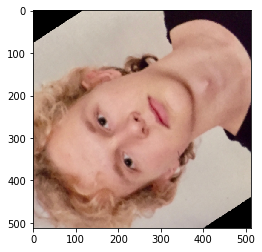

In [0]:
img = Image.open('drive/My Drive/Colab Notebooks/facenet/data/train_images/heorgii_bolotov/1.png')
print(img.format, img.size, img.mode)
t = transforms.Compose([
                    transforms.Resize(512), 
                    transforms.RandomAffine(180),
                    transforms.ColorJitter(hue=.05, saturation=.05),
                    transforms.CenterCrop(450), 
                    transforms.Resize(512), 
])
img_resized = Image.fromarray(np.array(t(img)))
print(img_resized.format, img_resized.size, img_resized.mode)
plt.imshow(img_resized)

In [0]:
from torchvision import datasets, transforms

dataset = datasets.ImageFolder('drive/My Drive/Colab Notebooks/facenet/data/train_images', transform=transforms.Resize((512, 512)))
dataset.classes, dataset.class_to_idx, dataset.samples

In [0]:
# default params 
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=10, thresholds=[0.6, 0.7, 0.7], 
    factor=0.709, post_process=True, device=device, 
)

for data_dir in ['drive/My Drive/Colab Notebooks/facenet/data/train_images', 
                 'drive/My Drive/Colab Notebooks/facenet/data/test_images']: 
    dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((512, 512)))
    dataset.samples = [(p, p.replace(data_dir, data_dir + '_cropped')) for p, _ in dataset.samples]

    loader = DataLoader(
        dataset, 
        num_workers=1,
        batch_size=10, 
        collate_fn=training.collate_pil
    )

    print(f'\n{data_dir}')
    for i, (x, y) in enumerate(loader):
        mtcnn(x, save_path=y)
        print(f'\nBatch {i + 1} of {len(loader)}', end='')

del mtcnn 
time.sleep(10)
display.clear_output()

[('drive/My Drive/Colab Notebooks/facenet/data/train_images/andrey_boykovskiy/1.png', 'drive/My Drive/Colab Notebooks/facenet/data/train_images_cropped/andrey_boykovskiy/1.png'), ('drive/My Drive/Colab Notebooks/facenet/data/train_images/andrey_boykovskiy/2.png', 'drive/My Drive/Colab Notebooks/facenet/data/train_images_cropped/andrey_boykovskiy/2.png'), ('drive/My Drive/Colab Notebooks/facenet/data/train_images/andrey_boykovskiy/3.png', 'drive/My Drive/Colab Notebooks/facenet/data/train_images_cropped/andrey_boykovskiy/3.png'), ('drive/My Drive/Colab Notebooks/facenet/data/train_images/andrey_boykovskiy/4.png', 'drive/My Drive/Colab Notebooks/facenet/data/train_images_cropped/andrey_boykovskiy/4.png'), ('drive/My Drive/Colab Notebooks/facenet/data/train_images/andrey_boykovskiy/5.png', 'drive/My Drive/Colab Notebooks/facenet/data/train_images_cropped/andrey_boykovskiy/5.png')]

drive/My Drive/Colab Notebooks/facenet/data/train_images

[('drive/My Drive/Colab Notebooks/facenet/data/tes

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt

trans = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25, resample=Image.BILINEAR),
])

data_dir = 'drive/My Drive/Colab Notebooks/facenet/data/train_images' + '_cropped'
dataset = datasets.ImageFolder(data_dir, transform=trans)
dataset.samples = [(p, p.replace(data_dir, data_dir + '_aug')) for p, _ in dataset.samples] 

if not os.path.exists(data_dir + '_aug'):
    os.mkdir(data_dir + '_aug')


for x, y in dataset:
    os.makedirs(os.path.dirname(y), exist_ok=True)
    x.save(y)

In [0]:
resnet1 = InceptionResnetV1(pretrained='vggface2').to(device)
resnet1

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [0]:
resnet = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=10).to(device)

In [0]:
for params in re

In [0]:
resnet

InceptionResnetV1(
  (conv2d_1a): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2a): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_2b): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool_3a): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_3b): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2d_4a): 

In [0]:
train_data_dir = 'drive/My Drive/Colab Notebooks/facenet/data/train_images' 
test_data_dir = 'drive/My Drive/Colab Notebooks/facenet/data/test_images'

batch_size = 6
epochs = 10

# num_cls = len(dataset.class_to_idx)
resnet = InceptionResnetV1(pretrained='vggface2', classify=True, num_classes=num_cls).to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.0001)
scheduler = MultiStepLR(optimizer, [5, 10])

trans = transforms.Compose([
      np.float32,
      transforms.ToTensor(),
      fixed_image_standardization
])

trans_aug = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25, resample=Image.BILINEAR),

        np.float32,
        transforms.ToTensor(),
        fixed_image_standardization
])

train_dataset = datasets.ImageFolder(train_data_dir + '_cropped', transform=trans)
train_aug_dataset = datasets.ImageFolder(train_data_dir + '_cropped', transform=trans_aug)
test_dataset = datasets.ImageFolder(test_data_dir + '_cropped', transform=trans)
train_loader = DataLoader(
    train_dataset, 
    num_workers=1, 
    batch_size=batch_size,
    sampler=SubsetRandomSampler(range(len(train_dataset)))
)
train_aug_loader = DataLoader(
    train_aug_dataset, 
    num_workers=1, 
    batch_size=batch_size,
    sampler=SubsetRandomSampler(range(len(train_aug_dataset)))
)
test_loader = DataLoader(
    test_dataset, 
    num_workers=1, 
    batch_size=batch_size,
    sampler=SubsetRandomSampler(range(len(test_dataset)))
)


loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [0]:
trans_aug = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25, resample=Image.BILINEAR),

        np.float32,
        transforms.ToTensor(),
        fixed_image_standardization
])

train_aug_dataset = datasets.ImageFolder(train_data_dir + '_cropped', transform=trans_aug)

train_aug_loader = DataLoader(
    train_aug_dataset, 
    num_workers=1, 
    batch_size=batch_size,
    sampler=SubsetRandomSampler(range(len(train_aug_dataset)))
)

In [0]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

resnet.eval()

training.pass_epoch(
    resnet, loss_fn, test_loader, batch_metrics=metrics, show_running=True, 
    device=device, writer=writer
)


for epoch in range(epochs):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('-' * 10)
    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler, 
        batch_metrics=metrics, show_running=True, device=device, writer=writer 
    )
    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, test_loader, batch_metrics=metrics, show_running=True, 
        device=device, writer=writer  
    )

writer.close()
time.sleep(10)
display.clear_output()

In [0]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

resnet.eval()

training.pass_epoch(
    resnet, loss_fn, test_loader, batch_metrics=metrics, show_running=True, 
    device=device, writer=writer
)


for epoch in range(5):
    print(f'\nEpoch {epoch + 1}/{epochs}')
    print('-' * 10)
    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_aug_loader, optimizer, scheduler, 
        batch_metrics=metrics, show_running=True, device=device, writer=writer 
    )
    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, test_loader, batch_metrics=metrics, show_running=True, 
        device=device, writer=writer  
    )

writer.close()
time.sleep(10)
display.clear_output()

In [0]:
test_dataset.idx_to_class = {v: c for c, v in test_dataset.class_to_idx.items()}
for (x, y) in test_dataset:
  print(test_dataset.idx_to_class[y])

names = [test_dataset.idx_to_class[y] for x, y in test_dataset]


test = torch.stack([x for x, y in test_dataset]).to(device)
emb = resnet(test).detach().cpu()

# print([y for x, y in test_dataset])
print(names)
_, predicted = emb.data.max(dim=1)
print([test_dataset.idx_to_class[i] for i in predicted.cpu().numpy()])


resnet.eval()
dists = [[(e1 - e2).norm().item() for e2 in emb] for e1 in emb]
print(pd.DataFrame(dists, columns=names, index=names))


andrey_boykovskiy
denis_moroz
dmytro_zikratyi
heorgii_bolotov
kolya_zubets
sacha_musak
vanya
vitali_kulinich
['andrey_boykovskiy', 'denis_moroz', 'dmytro_zikratyi', 'heorgii_bolotov', 'kolya_zubets', 'sacha_musak', 'vanya', 'vitali_kulinich']
['andrey_boykovskiy', 'denis_moroz', 'dmytro_zikratyi', 'heorgii_bolotov', 'kolya_zubets', 'sacha_musak', 'kolya_zubets', 'sacha_musak']
                   andrey_boykovskiy  denis_moroz  ...     vanya  vitali_kulinich
andrey_boykovskiy           0.000000     0.504366  ...  0.268898         0.304422
denis_moroz                 0.504366     0.000000  ...  0.555236         0.574057
dmytro_zikratyi             0.387179     0.490859  ...  0.493337         0.425154
heorgii_bolotov             0.420926     0.332616  ...  0.573976         0.611974
kolya_zubets                0.286821     0.447385  ...  0.210627         0.360662
sacha_musak                 0.300126     0.514315  ...  0.422234         0.297617
vanya                       0.268898     0.555

In [0]:
def summary(model):
    return sum([reduce(lambda a, b: a * b, x.size()) for x in model.parameters()])

print(f'{type(resnet)}\ntotal parameters number: {summary(resnet)}')